# Data Preparation
## Install and Import Libraries


In [1]:
pip install split-folders      # split-folders

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [10]:
from google.colab import drive

# Mount Google Drive to your Colab session
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix,classification_report


# splits train folders into train/validation with stratification
import splitfolders

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tensorflow - CNNs
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

<ipython-input-3-91d58b57bd28>:37: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices available.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU ({physical_devices[0].name}) is available.")

GPU (/physical_device:GPU:0) is available.


In [11]:
# paths for folders
FOLDERS     = ['train','test','val']
DIR_INPUT   = '/content/drive/MyDrive/dataset/chest_xray/'
DIR_WORKING = './'
DIR_MODELS  = os.path.join(DIR_WORKING,'models')
DIR_TRAIN   = os.path.join(DIR_WORKING,'train')
DIR_VAL     = os.path.join(DIR_WORKING,'val')
DIR_TEST    = os.path.join(DIR_WORKING,'test')
CLASS_LIST  = ['normal','bacteria','virus']


# Seed to reproduce random value
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Determine the Number of Images for each class
The dataset provided is split into 2 classes, normal/pneumonia. To build a multiclass model the images need to be split into three classes. The virial/bacterial pneumonia images can be delineated by the image names in the pneumonia folders.  The function below loops through each folder and displays the number of images of each class


In [12]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of normal, bacteria and virual xrays
    """

    # accumulators
    normal,bacterial,viral =0,0,0

    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:11} {:7}'.format('folder','normal','bacterial','viral',
                                                        'normal %','bacterial %','viral %')
    print(msg)
    print("-"*len(msg))

    #getting total instances of each class
    for folder in folders:
        for dirname, _, filenames in os.walk(path+folder):
            for filename in filenames:
                if 'normal' in dirname.lower():
                    normal+=1
                if  'bacteria' in filename.lower():
                    bacterial+=1
                if 'virus' in filename.lower():
                    viral+=1

        # total instances
        total = normal+bacterial+viral
        if total >0:
            n = round(normal/total,2)*100
            b = round(bacterial/total,2)*100
            v = round(viral/total,2)*100
        else:
            n,b,v = 0,0,0

        print("{:6} {:8} {:11} {:7} {:10} {:12} {:7} ".format(folder,normal,bacterial,viral,n,b,v))
        normal,bacterial,viral =0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS)


folder   normal   bacterial   viral   normal %  bacterial % viral %
-------------------------------------------------------------------
train      1350        2530    1345       26.0         48.0    26.0 
test        234         242     148       38.0         39.0    24.0 
val           8           8       0       50.0         50.0     0.0 


In [13]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    Create the dir_path/folder if it doesn't already exist
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)

    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)

    return folder_path


def split_files_by_class(working_dir,input_dir,folders):
    """
    Move images from the read-only input dir to the working dir
    Split the images by normal, bacteria and virual images
    """
    msg ="Separating Images By Class"
    print(msg)
    print("-"*len(msg))
    # loop through the train/test/val folders
    for folder in folders:

        # delete current files in working dir/folder
        class_folder = os.path.join(working_dir,folder)
        if path.exists(class_folder):
            shutil.rmtree(class_folder)

        # create class folders for bacteria and virus if they don't exist
        new_dir = create_dir(working_dir,folder)

        # loop through all files in each class folder
        for dirname, _, filenames in os.walk(input_dir + folder):
            # Normal Class:
            # Copy the full directory
            if 'normal' in dirname.lower():
                copyto=os.path.join(working_dir,folder,'normal')
                try:
                    shutil.copytree(dirname, copyto)
                except OSError as err:
                    print('Error copying normal directory from {} to {}:{}'.format(dirname,copyto,err))

            # Pneumonia Class:
            # Loop through files in the pneumonia folder
            # Split the files into bacteria /virus folders
            else:
                # create the folder/bacteria if it doesn't exist
                new_dir = create_dir(working_dir,folder + "/bacteria")

                # create the virus folder/virus folder if it doesn't exist
                new_dir = create_dir(working_dir,folder+ "/virus")

                # loop through all files in each folder and copy to bacteria or virus folders
                for filename in filenames:
                    if 'bacteria' in filename.lower():
                        new_dir = os.path.join(working_dir,folder,'bacteria')

                        # copy the file
                        try:
                            shutil.copy2(os.path.join(dirname,filename),new_dir)
                        except OSError as err:
                            print("Error copying file {} to {} with error:{}".format(filename,new_dir,err))

                    if 'virus' in filename.lower():
                        new_dir = os.path.join(working_dir,folder,'virus')

                        # copy the file
                        try:
                            shutil.copy2(os.path.join(dirname,filename),new_dir)
                        except OSError as err:
                            print("Error copying file {} to {} with error:{}".format(filename,new_dir,err))

    # print image summary by folder
    print("\n Images By Class After Separting Classes")
    print("-"*67)
    images_by_class(working_dir,folders)



# create model directory for saving trained models
create_dir(DIR_WORKING,'models',verbose=False)


# move validation files to train directory
split_files_by_class(DIR_WORKING,DIR_INPUT,FOLDERS)

Separating Images By Class
--------------------------
./train created
./train/bacteria created
./train/virus created


./test created
./test/bacteria created
./test/virus created


./val created
./val/bacteria created
./val/virus created



 Images By Class After Separting Classes
-------------------------------------------------------------------
folder   normal   bacterial   viral   normal %  bacterial % viral %
-------------------------------------------------------------------
train      1350        2530    1345       26.0         48.0    26.0 
test        234         242     148       38.0         39.0    24.0 
val           8           8       0       50.0         50.0     0.0 


In [16]:

#resamples instances by combining instances of train and validation in to temp folder

def move_val_to_train(working_dir,class_names):
    """
    Move the images in the validation folder to the train folder
    """
    for class_name in class_names:
        dir_from = os.path.join(working_dir,"val",class_name)
        dir_to = os.path.join(working_dir,"train",class_name)

        # for each file in val/class_name, copy to train/class_name
        for dirname, _, filenames in os.walk(dir_from):
            for filename in filenames:
                try:
                    shutil.copy2(os.path.join(dirname,filename),dir_to)
                except OSErrora as err:
                    print("Error moving file:{} with Error:{}".format(filename,err))

    # rename train folder to temp, remove train and val folders
    os.renames(os.path.join(working_dir,'train'),os.path.join(working_dir,'temp'))
    shutil.rmtree(os.path.join(working_dir,'val'))

    # print image summary by folder
    print("\n Images By Class After Moving Val to Train")
    print("-"*67)
    images_by_class(working_dir,["test",'temp'])


# move validation files to train directory
move_val_to_train(DIR_WORKING,CLASS_LIST)



 Images By Class After Moving Val to Train
-------------------------------------------------------------------
folder   normal   bacterial   viral   normal %  bacterial % viral %
-------------------------------------------------------------------
test        234         242     148       38.0         39.0    24.0 
temp       1358        2538    1345       26.0         48.0    26.0 


In [17]:
#distributes the new mixed instances from temp folder back to train and validation with ratio 80:20

def resample_train_val_images(working_dir,seed=SEED,split = (0.80,0.20)):
    """
    Resample the train images into train/val by the ratios given in split
    """

    # get paths
    # all train and val images will be in the temp folder
    input_dir  = os.path.join(working_dir,'temp')
    output_dir = os.path.join(working_dir)

    # resample
    splitfolders.ratio(input_dir, output_dir, seed=seed, ratio=split)

    # remove the temp folder
    try:
        shutil.rmtree(input_dir)
    except OSError as err:
        print("Error removing directory:{} with error:{}".format(input_dir,err))

    # print image summary by folder
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,["train","test","val"])


resample_train_val_images(DIR_WORKING)

Copying files: 5241 files [00:04, 1057.68 files/s]



 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   bacterial   viral   normal %  bacterial % viral %
-------------------------------------------------------------------
train      1086        2030    1076       26.0         48.0    26.0 
test        234         242     148       38.0         39.0    24.0 
val         272         508     269       26.0         48.0    26.0 


**Image Transformations**
+ rescale images to 150 x150
+ scale images
+ convert to RGB
+ specify class order in the generators
+ set seed for reproducibility

In [18]:
##Pre processing

# Set batch and image size
BATCH_SIZE    = 32
IMG_SIZE    = [150,150]

# Scale images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4185
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    classes     = CLASS_LIST,     # specify class order
    seed        = SEED
)

# validation images: 1047
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    classes     = CLASS_LIST,    # specify class order
    seed        = SEED
)

# test images:624
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    classes     = CLASS_LIST,    # specify class order
    seed        = SEED,
    shuffle     =False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
validation_steps = val_gen.n  // val_gen.batch_size

print("steps per epoch:{} \nvalidation steps:{}".format(steps_per_epoch,validation_steps))



Found 4192 images belonging to 3 classes.
Found 1049 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
steps per epoch:131 
validation steps:32


## View Xray Images
View sample images from the generators to ensure the transformations make sense. This function displays the processed train, test, or validation images from the image generators. It will display actual and predicted labels (if provided)

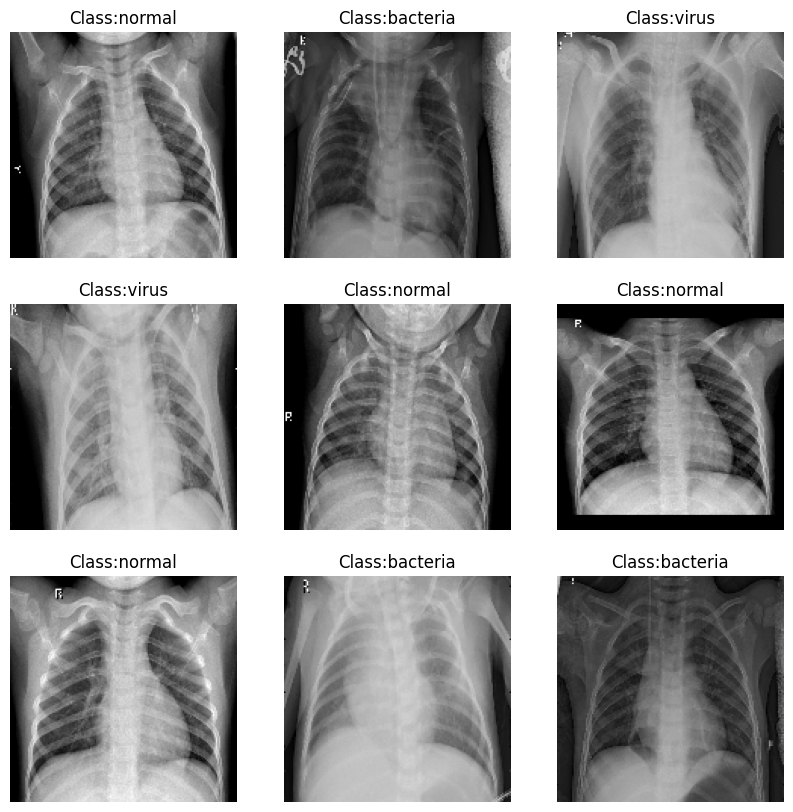

In [19]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2], CLASS_LIST))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_gen)

# Model Building and Evaluation Functions
Several functions were built to assist with model building, training, and evaluation

## Function:Plot Training Metrics
This function was used throughout the analysis to plot training metrics.  It plots loss by epochs, AUC by epochs, and the three-class confusion matrix with the training AUC metric.  AUC was chosen as the performance metric instead of accuracy due to the class imbalance in the training images

In [20]:
#metrics

def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """

    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")


    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)

    # create plots
    plt.subplots(figsize=(12,4))

    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[results/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()


    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Transfer Learning

+ trainable_layers: 'all' => keep all pretrained weights
+ trainable_layers: 'none'=> retrain all layers
+ trainable_layers: 'some'=> must provide the layer name,ranges to freeze

In [21]:
#transfer learning

def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num

    """
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")

    if trainable_layers=='some':

        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")

        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)


In [22]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node,
           the learning rate and performance metrics
    Output: A compiled CNN model
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(3,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learn_rate),
        loss      = 'categorical_crossentropy',
        metrics   = metric )

    model.summary()
    return model

In [23]:
# training parameters
EPOCHS        = 15
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

29084464/29084464 [==============================] - 0s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 1024)        4096      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dense_1 (D

<ipython-input-20-a8a67f5889f8>:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


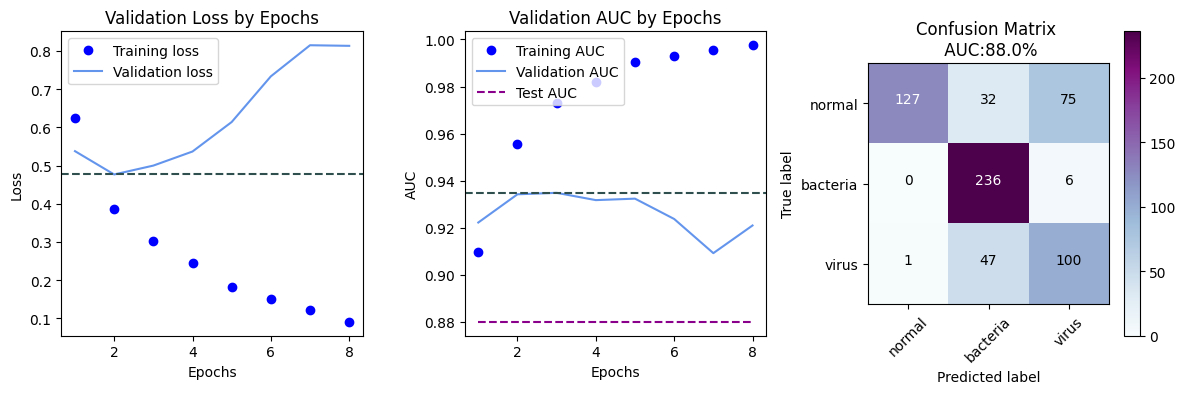

Total Time:7.9


In [24]:
# Train Model: Base Model
# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    validation_steps = validation_steps,
    verbose          = 2,
    callbacks        = callbacks  # early stopping
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,CLASS_LIST)

# Save the Model
model.save(os.path.join(DIR_MODELS,'base_model'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [25]:
# function to build the model
# add an additional conv layer with dropout and batch normalization
def build_transfer_model(conv_base,dropout,conv_nodes,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    """

    # clear previous run
    backend.clear_session()

    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout +0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(3,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy',
        metrics   = metric )

    model.summary()
    return model

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 1024)        4096      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         1179776   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 128)         0         
 D)                                                     

<ipython-input-20-a8a67f5889f8>:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


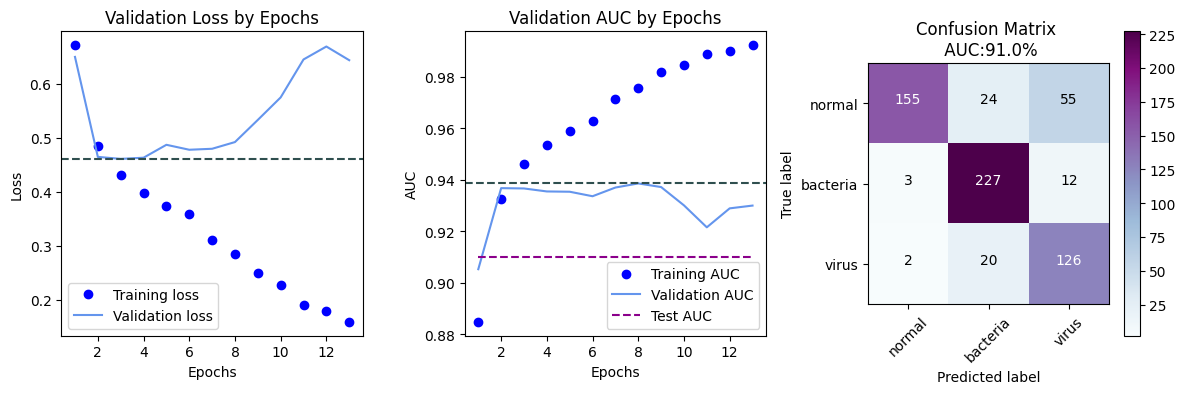

Total Time:13.1


In [26]:
# Train Model: Base + Additional Capacity (densenet is base mode)
# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,conv_nodes=128,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    validation_steps = validation_steps,
    verbose          = 2,
    callbacks        = callbacks  # early stopping
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# class dictionary
class_dict = test_gen.class_indices

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,CLASS_LIST)

# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

## Data Augmentation
The training plots show that the model is overfitting early in the epochs. Data augmentation was added to help the model generalize to novel data. Subtle transitions to the train images were added to the train image generator. Sample augmented images are shown below

Found 4192 images belonging to 3 classes.


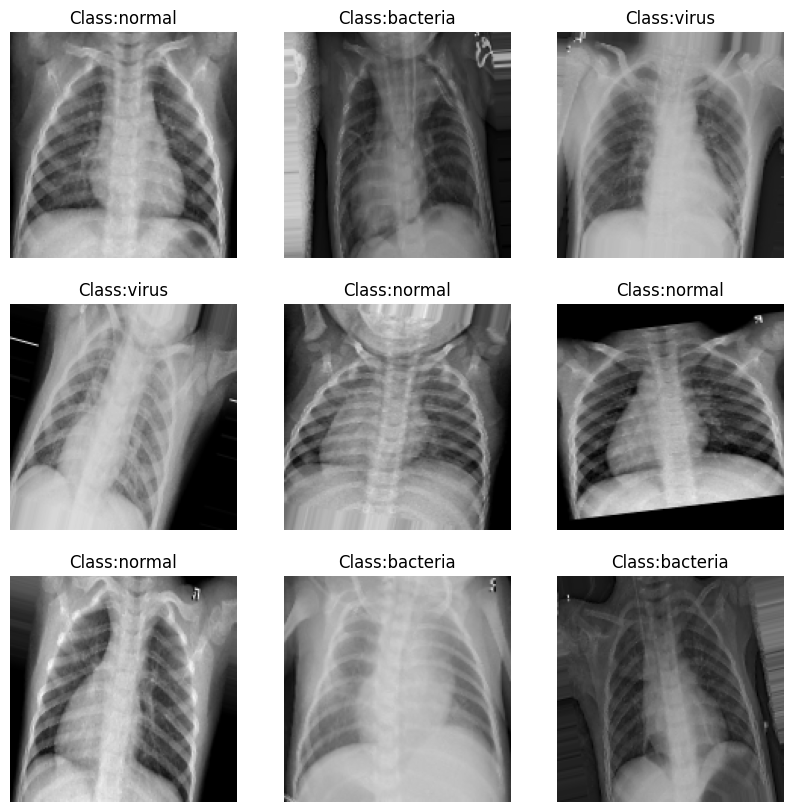

In [28]:
# Augment Training Images
train_images = ImageDataGenerator(rescale         = 1./255,
                                  rotation_range  = 15,
                                  zoom_range      = 0.15,
                                  horizontal_flip = True)

# Image Generators
# train images: 4185
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    classes     = CLASS_LIST,     # specify class order
    seed        = SEED
)


# View Augmented Training Images
show_images(train_gen)


No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 1024)        4096      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 1024)        9438208   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

<ipython-input-20-a8a67f5889f8>:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


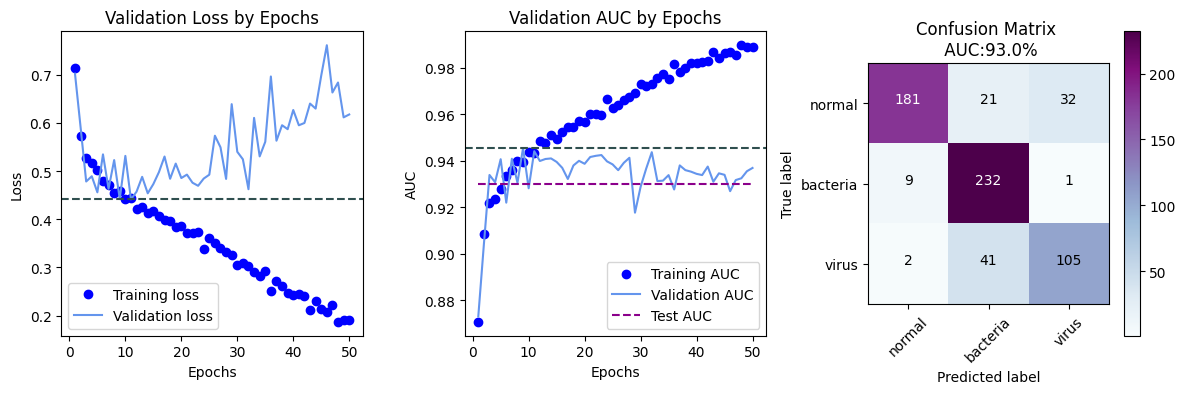

Total Time:60.45


In [29]:
# slow training
# increase the number of epochs, reduce the learning rate on plateau
EPOCHS        = 50
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=10, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc')]


# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,conv_nodes=1024,dense_node =512,learn_rate=1e-4,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    validation_steps = validation_steps,
    verbose          = 2,
    callbacks        = callbacks
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# class dictionary
class_dict = test_gen.class_indices

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,CLASS_LIST)

# Save Model
model.save(os.path.join(DIR_MODELS,'data_aug_model'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

# Final Model
Based on the previous full run the model had a diminishing return after 15 epochs.  The final model was run with 12 epochs and had a resulting AUC on the training set of approximately ~ 95%

No Layers Trainable: Using Base Model Weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 1024)        4096      
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 1024)        9438208   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                     

<ipython-input-20-a8a67f5889f8>:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


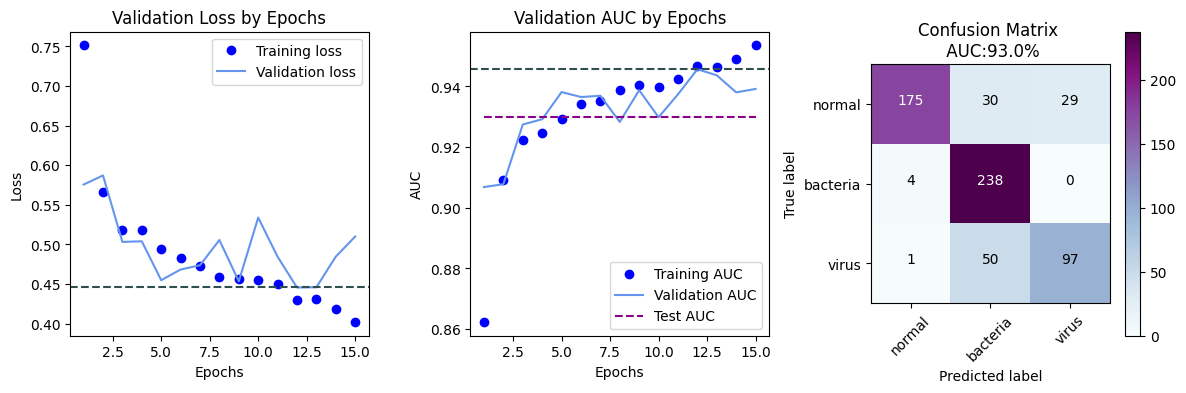

Total Time:18.7


In [30]:
# Final Run
# Limit epochs to avoid overfitting
EPOCHS        = 15
metrics       = [tf.keras.metrics.AUC(name='auc')]


# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,conv_nodes=1024,dense_node =512,learn_rate=1e-4,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    validation_steps = validation_steps,
    verbose          = 2
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# class dictionary
class_dict = test_gen.class_indices

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,CLASS_LIST)

# Save Model
model.save(os.path.join(DIR_MODELS,'final_model'))


# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

# View Images and Labels
We can view examples of actual and predicted labels with the show_images function by providing the predicted labels

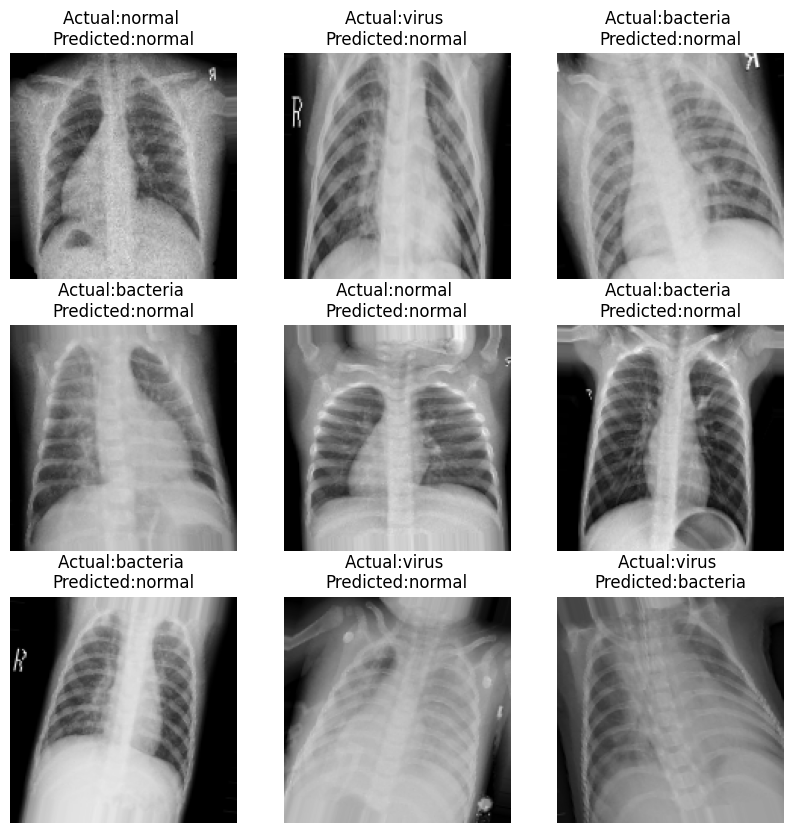

In [31]:
# show_images and labels
show_images(train_gen,y_pred)

# Conclusions
We can see from the confusion matrix and classification report that the model is best at identifying bacterial pneumonia (recall ~ 95%) which isn't surprising given that the class represents ~50% of the training and validation images.  Of the classifications that it gets wrong, it often misclassified normal<=>bacterial and bacterial<=>viral xrays.

Adding model capacity, searching for optimal hyperparameters and adding data augmentation resulted better performance on the test dataset.Additional data, upsampling or further data augmentation to balance classes for training could improve the overall performance

In [32]:
 print(classification_report(y_actual, y_pred, target_names=CLASS_LIST))

              precision    recall  f1-score   support

      normal       0.97      0.75      0.85       234
    bacteria       0.75      0.98      0.85       242
       virus       0.77      0.66      0.71       148

    accuracy                           0.82       624
   macro avg       0.83      0.80      0.80       624
weighted avg       0.84      0.82      0.81       624

